# All-optical control

Here we will see how to do two-photon optogenetics and calcium imaging simultaneously.

In [1]:
import brian2 as b2
from brian2 import np
import cleo
from cleo import opto, imaging, light
import matplotlib.pyplot as plt

# numpy faster than cython for lightweight example
# b2.prefs.codegen.target = 'numpy'
# for reproducibility
rng = np.random.default_rng(92)
np.random.seed(92)

cleo.utilities.style_plots_for_docs()

In [2]:
ng = b2.NeuronGroup(
    500,
    """dv/dt = (-(v - E_L) + Rm*Iopto) / tau_m : volt
    Iopto : amp""",
    threshold="v > -50*mV",
    reset="v=E_L",
    namespace={
        "tau_m": 20 * b2.ms,
        "Rm": 500 * b2.Mohm,
        "E_L": -70 * b2.mV,
    },
)
ng.v = -70 * b2.mV
cleo.coords.assign_coords_rand_rect_prism(ng, [-0.2, 0.2], [-0.2, 0.2], [0, 0.4])
sim = cleo.CLSimulator(b2.Network(ng))

## Microscope configuration

By default a scope selects neurons based on focus depth and assigns them a signal-to-noise ratio (SNR) based on soma size.
(Larger cells' SNR decays more slowly with distance from the focal plane.)
`focus_depth` and `soma_radius` are taken from scope parameters but can be overridden on injection.

In [3]:
scope = imaging.Scope(
    focus_depth=100 * b2.um,
    img_width=500 * b2.um,
    sensor=imaging.gcamp6f(doub_exp_conv=True),
)

sim.inject(scope, ng)  # uses scope's parameters
# optional overrides (we'll use a small soma to intentionally get few targets)
# sim.inject(scope, ng, focus_depth=200 * b2.um, soma_radius=2 * b2.um)

CLSimulator(io_processor=None, devices={Scope(sim=..., name='Scope', save_history=True, sensor=GECI(sim=None, name='gcamp6f', save_history=True, model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1\n\n            CaB_active = Ca_rest + b : mmolar  # add tiny bit to avoid /0\n            db/dt = beta : mmolar (clock-driven)\n            lam = 1/tau_off + 1/tau_on : 1/second\n            kap = 1/tau_off : 1/second\n            dbeta/dt = (                    # should be M/s/s\n                A * (lam - kap) * (Ca - Ca_rest)  # M/s/s\n                - (kap + lam) * beta        # M/s/s\n                - kap * lam * b    # M/s/s\n            ) : mmolar/second (clock-driven)\n            \nexc_factor = 1 : 1\n\n            dFF_baseline = 1 / (1 + (K_d / Ca_rest) ** n_H) : 1\n            dFF = exc_factor * rho_rel * dFF_max  * (\n                1 / (1 + (K_d / CaB_active) ** n_H)\n     

While Cleo adjusts SNR according to distance from the focal plane automatically, other SNR adjustments can be made manually by calling {meth}`~cleo.imaging.Scope.target_neurons_in_plane` to reflect factors such as heterogeneous soma sizes or indicator expression or reduced SNR with depth.

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (um)', ylabel='y (um)', zlabel='z (um)'>)

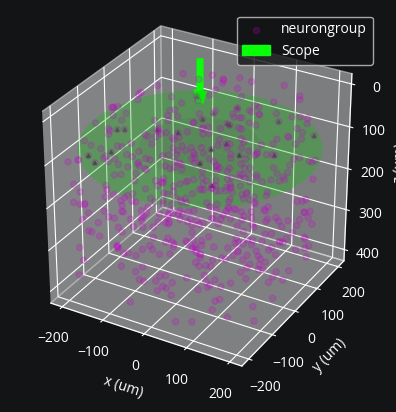

In [4]:
i_targets, noise_focus_factor, focus_coords = scope.target_neurons_in_plane(ng, focus_depth=300 * b2.um, soma_radius=2 * b2.um)
# scale noise std σ randomly to simulate biological variability
std_noise = scope.sensor.sigma_noise * noise_focus_factor * rng.normal(1, .2, len(i_targets))
# sim.inject(scope, ng, focus_depth=None, i_targets=i_targets, sigma_noise = std_noise)

cleo.viz.plot(ng, colors=['#c500cc'], sim=sim)

We can see targets off the visualized plane, resulting from our injections at 200 and 300 μm depths, resembling a multi-plane imaging experiment.

When `focus_depth` is set to `None`, corresponding to [sculpted holographic imaging](https://www.sciencedirect.com/science/article/pii/S0959438817301940), the scope will select all neurons in the volume, or the user can specify a list of neurons to select via `i_targets` on injection.

After all targets are specified, the sensor protein must also be injected.
Doing it this way allows for efficiency: the sensor protein is only injected into the imaged neurons.

In [5]:
scope.inject_sensor_for_targets()

## 2p stimulation configuration
Not sure how to scale 2P action spectrum in relation to the 1P spectrum, so we'll make it up:

In [6]:
opsin = opto.vfchrimson_4s()
opsin.spectrum.append((1060, .01))

In [7]:
sim.inject(opsin, ng)

CLSimulator(io_processor=None, devices={Scope(sim=..., name='Scope', save_history=True, sensor=GECI(sim=..., name='gcamp6f', save_history=True, model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1\n\n            CaB_active = Ca_rest + b : mmolar  # add tiny bit to avoid /0\n            db/dt = beta : mmolar (clock-driven)\n            lam = 1/tau_off + 1/tau_on : 1/second\n            kap = 1/tau_off : 1/second\n            dbeta/dt = (                    # should be M/s/s\n                A * (lam - kap) * (Ca - Ca_rest)  # M/s/s\n                - (kap + lam) * beta        # M/s/s\n                - kap * lam * b    # M/s/s\n            ) : mmolar/second (clock-driven)\n            \nexc_factor = 1 : 1\n\n            dFF_baseline = 1 / (1 + (K_d / Ca_rest) ** n_H) : 1\n            dFF = exc_factor * rho_rel * dFF_max  * (\n                1 / (1 + (K_d / CaB_active) ** n_H)\n      

Now, to target these neurons with 2P laser power, we use {meth}`~cleo.light.tp_light_from_scope` to create a `Light` object with a 2P laser {class}`~cleo.light.GaussianEllipsoid` light profile centered on each of the scope's targets:

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (um)', ylabel='y (um)', zlabel='z (um)'>)

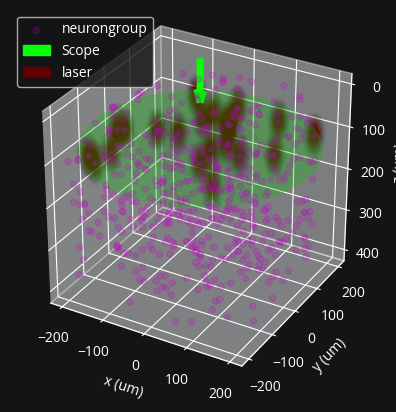

In [8]:
laser = light.tp_light_from_scope(scope, wavelength=1060*b2.nmeter, name='laser')
sim.inject(laser, ng)
cleo.viz.plot(ng, colors=['#c500cc'], sim=sim)

## Simulating an all-optical experiment

In [9]:
from cleo.ioproc import LatencyIOProcessor

# for seeing ground-truth spikes
i_all_targets = scope.i_targets_for_neuron_group(ng)
smon = b2.SpikeMonitor(ng, record=i_all_targets)
sim.network.add(smon)
# for debugging convolution model
stmon = b2.StateMonitor(
    scope.sensor.synapses[ng.name], ["b", "Ca", "beta", "CaB_active"], record=[1]
)
sim.network.add(stmon)

time_offsets = np.linspace(0, 500, scope.n)
amplitude_mW = 2
pulse_width_ms = 2
interpulse_ms = 20
pulse_starts_ms = np.concatenate(
    [
        [0],
        1000 + np.arange(0, 3*interpulse_ms, interpulse_ms),
        2000 + np.arange(0, 10*interpulse_ms, interpulse_ms),
        2000 + np.arange(0, 180, 20),
    ]
)
pulse_ends_ms = pulse_starts_ms + pulse_width_ms


class IOProc(LatencyIOProcessor):
    def process(self, state_dict, time_ms):
        t = (time_ms - time_offsets).reshape(scope.n, 1)
        # broadcast shape (n_neurons, n_pulses)
        on = np.any((pulse_starts_ms <= t) & (t < pulse_ends_ms), axis=1)
        # on = np.zeros(laser.n)
        # on[0] = 1
        return {"laser": on * amplitude_mW}, time_ms


sim.set_io_processor(IOProc(1))

sim.reset()
sim.run(3000 * b2.ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.41s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_VfChrimson_neurongroup', using method 'euler' (took 0.04s, trying other methods took 0.10s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_gcamp6f_neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]


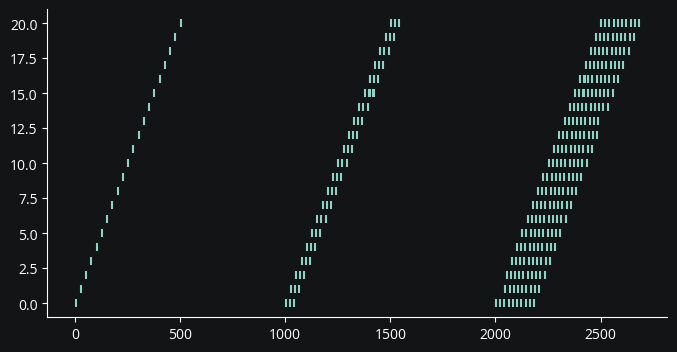

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
spt = np.empty((0,))
spi = np.empty((0,))
for i_target, i_ng in enumerate(i_all_targets):
    single_spt = smon.t[smon.i == i_ng]
    spt = np.concatenate((spt, single_spt))
    spi = np.concatenate((spi, np.full_like(single_spt, i_target)))
ax.scatter(spt / b2.ms, spi, marker='|')
# plt.scatter(spt, np.full_like(spt, i_target))

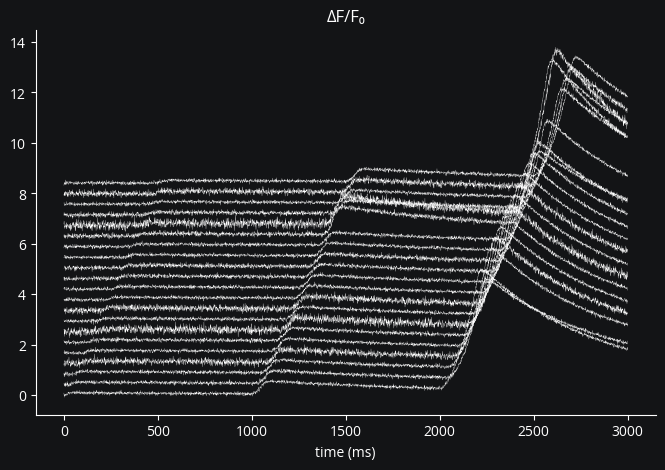

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
sep = np.percentile(scope.dFF, 60)
n2plot = len(i_all_targets)
# n2plot = 2
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(scope.t_ms[:], np.array(scope.dFF)[:, :n2plot] + sep*np.arange(n2plot), lw=.2, c='w')
ax.set(xlabel='time (ms)', title='ΔF/F₀')
# ax.add_artist(plt.Line2D([0, 1000], [sep, sep], color='k', lw=.5))
# ax.add_artist(AnchoredSizeBar(ax.transData, 1, "40% ΔF/F₀", color='w', loc=4, pad=0.1, borderpad=0.5, sep=5, frameon=False))

def add_sizebar(ax, size):
    asb = AnchoredSizeBar(ax.transData,
                          size,
                          str(size),
                          loc=8,
                          pad=0.1, borderpad=0.5, sep=5,
                          frameon=False)
    ax.add_artist(asb)

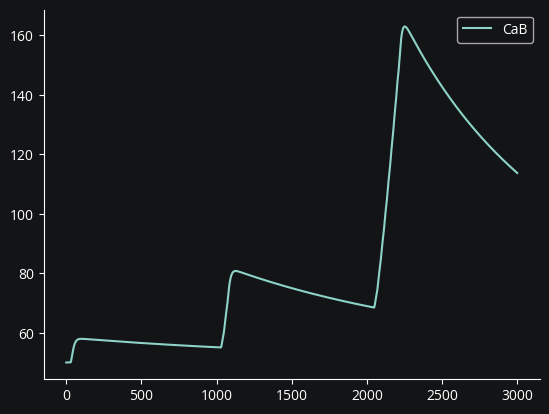

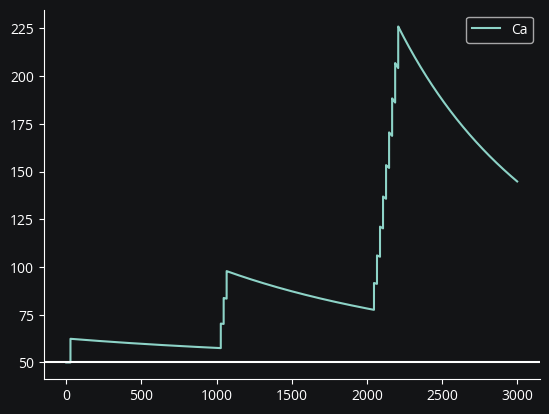

In [13]:
fig, ax = plt.subplots()
# ax.plot(stmon.t / b2.ms, stmon.b.T, label='b')
# ax.plot(stmon.t / b2.ms, stmon.beta.T, label='beta')
ax.plot(stmon.t / b2.ms, stmon.CaB_active.T / b2.nmolar, label='CaB')
ax.legend()
# fig, ax = plt.subplots()
# ax.plot(scope2.t_ms[:], np.array(scope2.dFF)[:, 0:n2plot] + sep*np.arange(n2plot), lw=.5)
# ax.set(xlabel='time (ms)')
fig, ax = plt.subplots()
ax.plot(stmon.t / b2.ms, stmon.Ca.T / b2.nmolar, label='Ca')
ax.axhline(scope.sensor.cal_model.Ca_rest / b2.nmolar)
ax.legend()

In [14]:
scope.sensor.dFF_1AP

0.09775500000000001